In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.9,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

tf.compat.v1.disable_eager_execution()

시퀀스 데이터를 처리하는 기본적인 딥러닝 모델은 **순환 신경망 (Recurrent Neural Network)**과 **1D 컨브넷 (1D ConvNet)** 두 가지입니다.

### 텍스트 데이터 다루기

텍스트는 가장 흔한 시퀀스 형태의 데이터입니다. 텍스트는 *단어의 시퀀스*나 *문자의 시퀀스*로 이해할 수 있습니다. 보통 *단어* 레벨에서 작업합니다. 시퀀스 처리용 딥러닝 모델은 문서 분류, 감성 분석, 저자 식별, 질문 응답 (Question Answering) 등의 애플리케이션에 적합합니다.

다른 신경망 모델과 마찬가지로 텍스트 원본을 입력으로 사용하지 못합니다. 수치형 텐서로 변환 *(vectorizing text)*하는 여러가지 방식이 있습니다
* 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환합니다
* 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환합니다
* 텍스트에서 단어나 문자의 **n-gram**을 추출하여 각 n그램을 하나의 벡터로 변환합니다

텍스트를 나누는 이런 단위 (단어, 문자, n-그램)을 **토큰 (token)**이라고 합니다. 그리고 텍스트를 토큰으로 변환하는 작업을 **토큰화 (tokenization)**라고 합니다. 생성된 토큰에 수치형 벡터를 연결합니다. 이런 벡터는 시퀀스 텐서로 묶여져서 신경망에 주입됩니다.

토근과 벡터를 연결하는 방법은 여러가지가 있습니다.
* One-hot encoding
* Token Embedding

<br></br>
![](../images/6-1-token.png)
<br></br>


### 단어와 문자의 원-핫 인코딩

단어에 고유한 정수 인덱스를 부여하고 이 정수 인덱스 i를 크기가 N (어휘 사전의 크기)인 이진 벡터로 변환합니다. 이 벡터는 i번째 인덱스만 1이고 나머지는 0입니다.

##### Word-level  One-hot encoding (example)

In [2]:
import numpy as np

## 초기 데이터: 각 문장이 샘플입니다.
samples = ["The cat sat on the mat.", "The dog at my homework."]

## 데이터에 있는 모든 토큰의 인덱스를 구축합니다
token_index = {}

for sample in samples:
    for word in sample.split():
        if word not in token_index:
            ## 단어마다 고유한 인덱스를 할당합니다. 인덱스 0은 사용하지 않습니다
            token_index[word] = len(token_index) + 1

##샘플을 벡터로 변환합니다. 각 샘플에서 max_length까지 단어만 사용합니다
max_length = 10

#결과를 저장할 배열입니다
results = np.zeros(shape = (len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [3]:
results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

##### Char-level One-hot encoding (example)

In [4]:
import string

samples = ["The cat sat on the mat.", "The dog at my homework."]

## 출력 가능한 모든 아스키(ASCII) 문자
characters = string.printable 

token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1

In [5]:
results

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

케라스에는 원본 덱스트 데이터를 단어 또는 문자 수준의 원-핫 인코딩으로 변환해주는 유틸리가 있습니다.

##### 케라스를 사용한 단어 수준의 원-핫 인코딩

In [6]:
from keras.preprocessing.text import Tokenizer

samples = ["The cat sat on the mat.", "The dog at my homework."]

## 가장 빈도가 높은 1000개의 단어만 선택하도록 합니다
tokenizer = Tokenizer(num_words = 1000)

## 단어 인덱스를 구축합니다
tokenizer.fit_on_texts(samples)

## 문자열을 정수 인덱스의 리스트로 변환합니다.
sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode = "binary")

## 계산된 단어 인덱스를 구합니다
word_index = tokenizer.word_index

print("%s개의 고유한 토큰을 찾았습니다." % len(word_index))

9개의 고유한 토큰을 찾았습니다.


원-핫 인코딩의 변종중 하나는 **원-핫 해싱 (one-hot hashing)** 기법입니다. 
* 어휘 사전에 있는 고유한 토큰의 수가 너무 커서 모두 다루기 힘들때 사용합니다. 
* 각 단어에 명시적으로 인덱스를 할당하고 이 인덱스를 딕셔너리에 저장하는 대신에 단어를 해싱하여 고정된 크기의 벡터로 변환합니다. 
* 장점은 명시적인 단어 인덱스가 필요 없기때문에 메모리를 절약하고
* 전체 데이터를 확인하지 않고 토큰을 생성할 수 있습니다.
* 단점은 해시 충돌입니다
* 두개의 단어가 같은 해시를 만들면 머신 러닝 모델은 두 단어의 차이를 인식하지 못합니다

##### 해싱 기법을 사용한 단어 수준의 원-핫 인코딩

In [7]:
samples = ["The cat sat on the mat.", "The dog at my homework."]

## 단어를 크기가 1000인 벡터에 저장합니다
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

    results

### 단어 임베딩 사용하기

단어와 벡터를 연결시키는 인기있는 방법은 **단어 임베딩**이라는 밀집 단어 벡터를 사용하는 것입니다.
* 원-핫 인코딩으로 만들어진 벡터는 희소 (sparse)하고 고차원입니다. (어휘 사전에 있는 단어의 수와 차원이 같습니다)
* 반면에 단어 임베딩은 저차원의 실수형 벡터입니다
* 원-핫 인코딩과 달리 단어 임베딩은 데이터로부터 학습됩니다
* 단어 임베딩이 더 많은 정보를 적은 차원에 저장합니다

<br></br>
![](../images/6-1-wordembed.png)
<br></br>

단어 임베딩을 만드는 방법은 2가지 입니다.
* (문서 분류나 감성 예측같은) 관심 대상인 문제와 함께 단어 임베딩을 학습합니다. 이 경우에는 랜덤한 단어 벡터로 시작해서 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습합니다.
* 미리 계산된 단어 임베딩을 로드합니다. 이를 **사전 훈련된 단어 임베딩 (pretrained word embedding)**이라고 합니다.

#### Embedding 층을 사용하여 단어 임베딩 학습하기

단어와 밀집 벡터를 연관짓는 가장 간단한 방법은 랜덤하게 벡터를 선택하는 것입니다.
* 문제점은 임베딩 공간이 구조적이지 않다는 것
* accurate와 exact는 대부분 문장에서 비슷한 의미로 사용되지만 다른 임베딩을 가집니다
* 심층 신경망은 이런 임의의 구조적이지 않은 임베딩 공간을 이해하기 어렵습니다

단어 벡터 사이에 추상적이고 기하학적인 관계를 얻으려면 단어 사이에 있는 의미 관계를 반영해야합니다.
* 단어 임베딩은 언어를 기하학적 공간에 매핑하는 것입니다.
* 잘 구축된 임베딩 공간에서는 동의어가 비슷한 단어 벡터로 임베딩될 것입니다.
* 두 단어 사이의 거리 (L2 거리)는 단어 사이의 의미 거리와 관계되어 있습니다
    * 가까운 거리의 단어는 비슷한 뜻을 가진 단어
    * 멀리 떨어진 단어는 다른 의미의 단어
* 거리뿐만 아니라 방향도 의미를 가질 수 있습니다.

실제 단어 임베딩 공간에서 의미있는 기하학적 변환의 일반적인 예는 **성별**과 **복수 (plural)** 벡터입니다.
* 예를 들어 *king* 벡터에 *female* 벡터를 더하면 *queen* 벡터가 됩니다.
* *king* 벡터에 *plural* 벡터를 더하면 *kings* 벡터가 됩니다.
* 단어 임베딩 공간은 전형적으로 이런 해석 가능하고 잠재적으로 유용한 수천개의 벡터를 특성으로 가집니다.

영어로 된 영화 리뷰 감성 모델을 위한 단어 임베딩 공간은 영어로 된 법률 문서 분류 모델을 위한 임베딩 공간과 다릅니다. 특정 의미 관계의 중요성이 작업에 따라 다르기 떄문입니다.

따라서 새로운 작업에는 새로운 임베딩을 학습하는 것이 타당합니다.

##### Embedding 층의 객체 생성하기

In [8]:
from keras.layers import Embedding

## Embedding 층은 적어도 2개의 매개변수를 받습니다
## 가능한 토큰의 수 (1000)와 임베딩 차원 (64)입니다
embedding_layer = Embedding(1000, 64)

Embedding Layer는 크기가 (samples, sequence_length)인 2D 정수 텐서를 입력으로 받습니다.
* 각 샘플은 정수의 시퀀스입니다.
* 배치에 있는 모든 시퀀스는 길이가 같아야 합니다.
* 작은 길이의 시퀀스는 0으로 패딩되고 길이가 긴 시퀀스는 잘립니다.

Embedding Layer는 크기가 (samples, sequence_length, embedding_dimensionality)인 3D 실수형 텐서를 반환합니다.
* 이런 3D 텐서는 RNN 층이나 2D 합성곱 층에서 처리됩니다

Embedding Layer의 객체를 생성할때 가중치는 다른 층과 마찬가지로 랜덤하게 초기화됩니다. 훈련하면서 이 단어 벡터는 역전파를 통해 점차 조정되어 이어지는 모델이 사용할 수 있도록 임베딩 공간을 구성합니다. 훈련이 끝나면 임베딩 공간은 특정 문제에 특화된 구조를 많이 가지게 됩니다

##### Embedding Layer에 사용할 IMDB 데이터 로드

In [9]:
from keras.datasets import imdb
from keras import preprocessing

## 특성으로 사용할 단어의 수
max_features = 10000

## 사용할 텍스트의 길이
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

##### IMDB 데이터에 Embedding 층과 분류기 사용하기

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length = maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 50us/sample - loss: 0.6700 - acc: 0.6223 - val_loss: 0.6212 - val_acc: 0.6906
Epoch 2/10
 3552/20000 [====>.........................] - ETA: 0s - loss: 0.5878 - acc: 0.7447

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20000/20000 [==============================] - 1s 30us/sample - loss: 0.5420 - acc: 0.7503 - val_loss: 0.5261 - val_acc: 0.7308
Epoch 3/10
20000/20000 [==============================] - 1s 29us/sample - loss: 0.4610 - acc: 0.7862 - val_loss: 0.4988 - val_acc: 0.7450
Epoch 4/10
20000/20000 [==============================] - 1s 30us/sample - loss: 0.4221 - acc: 0.8079 - val_loss: 0.4931 - val_acc: 0.7514
Epoch 5/10
20000/20000 [==============================] - 1s 29us/sample - loss: 0.3964 - acc: 0.8225 - val_loss: 0.4941 - val_acc: 0.7528
Epoch 6/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.3755 - acc: 0.8345 - val_loss: 0.4967 - val_acc: 0.7586
Epoch 7/10
20000/20000 [==============================] - 1s 30us/sample - loss: 0.3572 - acc: 0.8453 - val_loss: 0.5009 - val_acc: 0.7554
Epoch 8/10
20000/20000 [==============================] - 1s 29us/sample - loss: 0.3396 - acc: 0.8550 - val_loss: 0.5053 - val_acc: 0.7566
Epoch 9/10
20000/20000 [==============

약 75%의 검증 정확도가 나옵니다. 하지만 임베딩 시퀀스를 펼치고 하나의 Dense 층을 훈련했으므로 입력 시퀀스에 있는 각 단어를 독립적으로 다루었습니다. 단어 사이의 관계나 문장 구조를 고려하지 않았습니다. 각 시퀀스 전체를 고려한 특성을 학습하도록 임베딩 층 위에 순환 층이나 1D 합성곱 층을 추가하는 것이 좋습니다

#### 사전 훈련된 단어 임베딩 사용하기

훈련 데이터가 부족하면 작업에 맞는 단어 임베딩을 학습할 수 없습니다. 이때는 어떻게 해야할까요?

풀려는 문제와 함께 담어 임베딩을 학습하는 대신 미리 계산된 임베딩 공간에서 임베딩 벡터를 로드할 수 있습니다. 이런 임베딩 공간은 뛰어난 구조와 유용한 성질을 가지고 있어서 언어 구조의 일반적인 측면을 잡아낼 수 있습니다. 충분한 데이터가 없어서 자신만의 좋은 특성을 학습하지 못하지만 꽤 일반적인 특성이 필요할 때입니다. 이런 경우에는 다른 문제에서 학습한 특성을 재사용하는 것이 합리적입니다.

단어 임베딩은 일반적으로 단어 출현 통계를 사용하여 계산합니다. 단어를 위해 밀집된 저차원 임베딩 공간을 비지도 학습 방법으로 계산하는 아이디어가 적용되었습니다
* 2013년 구글이 개발한 Word2vec은 성별처럼 구체적인 의미가 있는 속성을 잡아냅니다
* 2014년 스탠포드에서 개발한 Glove는 단어의 동시 출현 통계를 기록한 행렬을 분해하는 방법을 사용합니다.

### 모든 내용을 적용하기: 원본 텍스트에서 단어 임베딩까지

문장들을 벡터의 시퀀스로 임베딩하고 펼친 후 그 위에 Dense층을 훈련합니다. 여기서는 사전 훈련된 단어 임베딩을 사용하겠습니다. 케라스에 포함된 IMDB 데이터는 미리 토큰화가 되어있어서 이를 사용한 대신 원본 텍스트 데이터를 내려받아 처음부터 시작하겠습니다.

#### 원본 IMDB 텍스트 내려받기

##### IMDB 원본 데이터 전처리하기

In [11]:
import os

imdb_dir = "./data/aclImdb/"
train_dir = os.path.join(imdb_dir, "train")

labels = []
texts = []

for label_type in ["neg", "pos"]:
    dir_name = os.path.join(train_dir, label_type)
    print(dir_name)
    
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding = "utf8")
            texts.append(f.read())
            f.close()
            
            if label_type == "neg":
                labels.append(0)
                
            else:
                labels.append(1)

./data/aclImdb/train/neg
./data/aclImdb/train/pos


#### 데이터 토큰화

텍스트를 벡터로 만들고 훈련 세트와 검증 세트로 나누겠습니다. 사전 훈련된 단어 임베딩은 훈련 데이터가 부족한 문제에 특히 유용합니다. 그래서 다음과 같이 훈련 데이터를 처음 200개의 샘플로 제한합니다. 이 모델은 200개의 샘플을 학습한 후 영화 리뷰를 분류할 것입니다.

##### IMDB 원본 데이터의 텍스트를 토큰화하기

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("%s개의 고유한 토큰을 찾았습니다" % len(word_index))

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)

print("데이터 텐서의 크기:", data.shape)
print("레이블 텐서의 크기:", labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


#### 임베딩 전처리

압축 해제한 파일을 파싱하여 단어와 이에 상응하는 벡터 표현을 매칭하는 인덱스를 만듭니다.

##### Glove 단어 임베딩 파일 파싱하기

In [13]:
glove_dir = "./data/"

embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.100d.txt"), encoding = "utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = "float32")
    embeddings_index[word] = coefs
f.close()

print("%s개의 단어 벡터를 찾았습니다" % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다


그 다음 Embedding 층에 주입할 수 있도록 임베딩 행렬을 만듭니다. 
* 크기는 **(max_words, embedding_dim)**
* 행렬의 i번째 원소는 단어 인덱스의 i번째 단어에 상응하는 embedding_dim차원 벡터입니다
* 인덱스 0은 어떤 단어나 토큰도 아닐 경우를 나타냅니다

##### Glove 단어 임베딩 행렬 준비하기

In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### 모델 정의하기

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### 모델에 GloVe 임베딩 로드하기

Embedding 층은 하나의 가중치 행렬을 가집니다. 이 행렬은 2D 행렬이고 각 i번째 원소는 i번째 인덱스에 상응하는 단어 벡터입니다.

##### 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기

In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

추가적으로 Embedding 층을 동결합니다. 사전 훈련된 부분이 업데이트되면 안됩니다. 이미 알고 있던 정보를 모두 잃게 됩니다.

#### 모델 훈련과 평가

In [17]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

model.save_weights("pretrained_glove_model.h5")

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 1ms/sample - loss: 2.2651 - acc: 0.4950 - val_loss: 0.6926 - val_acc: 0.5158
Epoch 2/10
200/200 [==============================] - 0s 867us/sample - loss: 0.6538 - acc: 0.6450 - val_loss: 0.6861 - val_acc: 0.5486
Epoch 3/10
200/200 [==============================] - 0s 795us/sample - loss: 0.6413 - acc: 0.6750 - val_loss: 0.8030 - val_acc: 0.5071
Epoch 4/10
200/200 [==============================] - 0s 805us/sample - loss: 0.5536 - acc: 0.6650 - val_loss: 0.7395 - val_acc: 0.5142
Epoch 5/10
200/200 [==============================] - 0s 806us/sample - loss: 0.3162 - acc: 0.9250 - val_loss: 0.6890 - val_acc: 0.5727
Epoch 6/10
200/200 [==============================] - 0s 812us/sample - loss: 0.3382 - acc: 0.8650 - val_loss: 0.6885 - val_acc: 0.5701
Epoch 7/10
200/200 [==============================] - 0s 799us/sample - loss: 0.1694 - acc: 0.9800 - val_loss: 0.8018 - val_acc: 0.5406
Ep

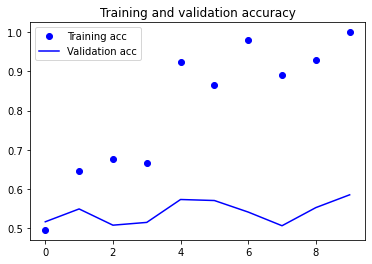

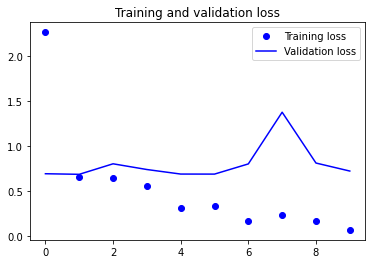

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 모델은 매우 빠르게 과대적합 시작합니다. 샘플 수가 매우 적기때문입니다. 같은 이유로 검증 정확도와 훈련 정확도 사이에 차이가 큽니다.

사전 훈련된 단어 임베딩을 사용하지 않거나 임베딩 층을 동결하지 않고 같은 모델을 훈련할 수 있습니다. 
* 데이터가 풍부하게 있다면 사전 훈련된 단어 임베딩보다 일반적으로 훨씬 성능이 좋습니다.

##### 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

model.save_weights("pretrained_glove_model2.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.6950 - acc: 0.4800 - val_loss: 0.6926 - val_acc: 0.5156
Epoch 2/10
 32/200 [===>..........................] - ETA: 0

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


200/200 [==============================] - 0s 892us/sample - loss: 0.5058 - acc: 0.9850 - val_loss: 0.6918 - val_acc: 0.5224
Epoch 3/10
200/200 [==============================] - 0s 837us/sample - loss: 0.2898 - acc: 1.0000 - val_loss: 0.7018 - val_acc: 0.5140
Epoch 4/10
200/200 [==============================] - 0s 927us/sample - loss: 0.1298 - acc: 1.0000 - val_loss: 0.7183 - val_acc: 0.5144
Epoch 5/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.0615 - acc: 1.0000 - val_loss: 0.7217 - val_acc: 0.5144
Epoch 6/10
200/200 [==============================] - 0s 903us/sample - loss: 0.0313 - acc: 1.0000 - val_loss: 0.7102 - val_acc: 0.5235
Epoch 7/10
200/200 [==============================] - 0s 838us/sample - loss: 0.0175 - acc: 1.0000 - val_loss: 0.7136 - val_acc: 0.5248
Epoch 8/10
200/200 [==============================] - 0s 833us/sample - loss: 0.0101 - acc: 1.0000 - val_loss: 0.7180 - val_acc: 0.5233
Epoch 9/10
200/200 [==============================] - 0s 835u

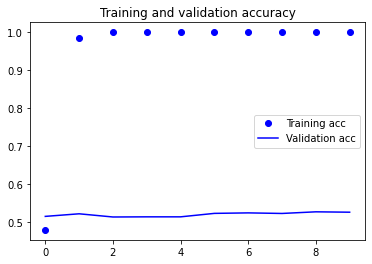

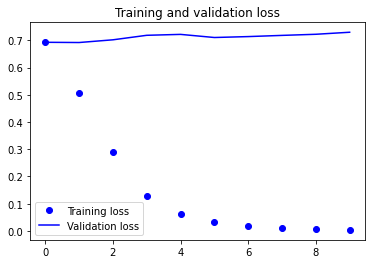

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도는 50% 초반에 멈추어 있습니다. 이 예제에서는 사전 훈련된 단어 임베딩을 사용하는 것이 임베딩을 함께 훈련하는 것보다 낫습니다. 훈련 샘플의 수를 늘리면 금새 상황이 바뀝니다. 

##### 테스트 데이터 토큰화하기

In [21]:
test_dir = os.path.join(imdb_dir, "test")

labels = []
texts = []

for label_type in ["neg", "pos"]:
    dir_name = os.path.join(test_dir, label_type)
    print(dir_name)
    
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding = "utf8")
            texts.append(f.read())
            f.close()
            
            if label_type == "neg":
                labels.append(0)
                
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)

./data/aclImdb/test/neg
./data/aclImdb/test/pos


##### 테스트 세트에서 모델 평가하기

In [22]:
model.load_weights("pretrained_glove_model.h5")
model.evaluate(x_test, y_test)

[0.7292915500259399, 0.57468]

테스트 정확도는 겨우 50% 정도입니다. 적은 수의 훈련 샘플로 작업하는 것은 어려운 일입니다